In [1]:
# for Qwen 30B, each token is 0.00009150208 GB
# each chunk is 0.00292806667 GB

from collections import OrderedDict
class ChunkCache:
    def __init__(self, capacity: int):

        self.chunk_db = OrderedDict()
        # capacity in chunks
        self.capacity = capacity
        self.chunks = 0
        self.hash_counter = 0
        self.hash_distances = []
    def on_new_chunk(self, chunk: int) -> bool:
        self.hash_counter += 1
        if chunk in self.chunk_db:
            self.chunk_db.move_to_end(chunk)
            hash_id_distance = self.hash_counter - self.chunk_db[chunk]
            # if hash_id_distance < 10:
            #     print(f"Chunk {chunk} has a hash distance of {hash_id_distance}, current hash counter is {self.hash_counter}, db: {self.chunk_db}")
            self.hash_distances.append(hash_id_distance)
            self.chunk_db[chunk] = self.hash_counter
            return True
        # True hash distances occur when we miss a cached chunk
        # self.hash_counter += 1
        self.chunk_db[chunk] = self.hash_counter
        self.chunks += 1
        if self.chunks > self.capacity:
            # LRU (remove oldest)
            self.chunk_db.popitem(last=False)
            self.chunks -= 1
        return False
    
    def on_chunk_removed(self, chunk: int):
        del self.chunk_db[chunk]
        

In [2]:
def process_hash_ids(chunk_cache: ChunkCache, hash_ids: list[int]) -> float: 
    hit_count = 0
    for hash_id in hash_ids: 
        has_hit = chunk_cache.on_new_chunk(hash_id)
        if has_hit:
            hit_count += 1
    return hit_count

In [3]:
import hashlib
import numpy as np
import pandas as pd

def calculate_prefix_hash(hash_ids: list[int]) -> list[int]:
    curr_hash = hash_ids[0]
    ret = [curr_hash]
    for hash_id in hash_ids[1:]:
        curr_hash = hashlib.sha256(f"{curr_hash}{hash_id}".encode()).hexdigest()
        curr_hash = int(curr_hash, 16) % 1_000_000_007
        ret.append(curr_hash)
    return ret

def get_cdf_xy(arr: np.array):
    values, counts = np.unique(arr, return_counts=True)
    y = np.cumsum(counts) / np.sum(counts)
    return values, y

In [4]:
from functools import partial
def add_time(time: pd.Timestamp, inc: int) -> pd.Timestamp:
    return time + pd.Timedelta(inc, unit="ms")

add_time_func = partial(add_time, inc=5)

add_time_func(pd.Timestamp("2025-01-01 00:00:00"))
print(add_time_func(pd.Timestamp("2025-01-01 00:00:00")))

def inc_hash_ids(hash_ids: list[int], inc: int) -> list[int]:
    new_hash_ids = []
    for hash_id in hash_ids: 
        new_hash_ids.append(hash_id + inc)
    return new_hash_ids

inc_hash_ids_func = partial(inc_hash_ids, inc=1)

inc_hash_ids_func([1, 2, 3])
print(inc_hash_ids_func([1, 2, 3]))

2025-01-01 00:00:00.005000
[2, 3, 4]


In [5]:
import pandas as pd
import datetime

single_entry = pd.read_json("gmi_trace_2.jsonl", lines=True).iloc[0]
single_entry_time = single_entry["timestamp"]
print(f"type(single_entry_time): {type(single_entry_time)}")
print(single_entry_time)

single_entry_time += pd.Timedelta(5, unit="ms")
print(f"type(single_entry_time): {type(single_entry_time)}")
print(single_entry_time)



type(single_entry_time): <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2025-08-08 04:54:09.912095794
type(single_entry_time): <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2025-08-08 04:54:09.917095794


In [6]:
# add users to the trace respecting the current characteristics
import copy
from functools import partial
import pandas as pd

def clone_users(df: pd.DataFrame, clone_count: int) -> pd.DataFrame: 
    def add_time(time, inc: int):
        # print(time)
        after_time = time + pd.Timedelta(inc, unit="ns")
        # print(after_time)
        return after_time
    def inc_hash_ids(hash_ids: list[int], inc: int) -> list[int]:
        new_hash_ids = []
        for hash_id in hash_ids: 
            new_hash_ids.append(hash_id + inc)
        return new_hash_ids

    df_copies = []
    for i in range(1,clone_count+1):
        add_time_func = partial(add_time, inc=5*i)
        inc_hash_ids_func = partial(inc_hash_ids, inc=i)
        df_copy = df.copy(deep=True)
        # print(df_copy["timestamp"])
        df_copy["timestamp"] = df_copy["timestamp"].apply(add_time_func)
        # print(df_copy["timestamp"])
        df_copy["hash_ids"] = df_copy["hash_ids"].apply(inc_hash_ids_func)
        df_copies.append(df_copy)
    print(f"len(df_copies): {len(df_copies)}")
    # for i, df_copy in enumerate(df_copies):
    #     print(f"len(df_copy {i}): {len(df_copy)}")
    #     print(df_copy["timestamp"])
    new_df = pd.concat([df] + df_copies, ignore_index=True)
    print(len(new_df))
    return new_df

# test_df = pd.read_json("gmi_fake_trace.jsonl", lines=True)
# test_df
df = pd.read_json("gmi_trace_2.jsonl", lines=True)
df = df.sort_values(by='timestamp').reset_index(drop=True)
df["prefix_hash"] = df["hash_ids"].apply(calculate_prefix_hash)
df

,timestamp,datetime,input_length,output_length,hash_ids,prefix_hash
0,2025-08-08 04:54:09.912095794,2025-08-08 04:54:09.912,1961,75,"[2843241808, 137021281, 3846380862, 3623882930...","[2843241808, 210978553, 930451284, 20749910, 5..."
1,2025-08-08 04:54:09.981487903,2025-08-08 04:54:09.981,5877,126,"[4210758544, 1547440619, 3288419075, 349568167...","[4210758544, 856436508, 348017253, 641853744, ..."
2,2025-08-08 04:54:11.041991046,2025-08-08 04:54:11.041,3872,87,"[4210758544, 1547440619, 3288419075, 349568167...","[4210758544, 856436508, 348017253, 641853744, ..."
3,2025-08-08 04:54:11.452795601,2025-08-08 04:54:11.452,3399,446,"[3799507203, 3056364765, 180296668, 1703753618...","[3799507203, 380287505, 522880191, 714927203, ..."
4,2025-08-08 04:54:11.530968451,2025-08-08 04:54:11.530,3513,76,"[618748680, 2346545311, 896378354, 1364564397,...","[618748680, 427334740, 644539247, 306586790, 1..."
...,...,...,...,...,...,...
6014,2025-08-08 05:54:07.765955504,2025-08-08 05:54:07.765,4792,138,"[4210758544, 1547440619, 3288419075, 349568167...","[4210758544, 856436508, 348017253, 641853744, ..."
6015,2025-08-08 05:54:08.323805643,2025-08-08 05:54:08.323,5294,135,"[4210758544, 1547440619, 3288419075, 349568167...","[4210758544, 856436508, 348017253, 641853744, ..."
6016,2025-08-08 05:54:08.384718052,2025-08-08 05:54:08.384,3905,114,"[4210758544, 1547440619, 3288419075, 349568167...","[4210758544, 856436508, 348017253, 641853744, ..."
6017,2025-08-08 05:54:08.628109201,2025-08-08 05:54:08.628,5750,104,"[4210758544, 1547440619, 3288419075, 349568167...","[4210758544, 856436508, 348017253, 641853744, ..."


In [7]:
df = clone_users(df, clone_count=99)

len(df_copies): 99
601900


In [8]:

# number of GigaBytes in your KV Cache
# 0. unlimited cache
# cache_gb = 10000000000
# 1. vllm prefix caching
cache_gb = 10
# 2. LMCache with 160 GB CPU Size
# cache_gb = 160

# for Qwen 30B, each token is 0.00009150208 GB
# each chunk (of 32 tokens) is 0.00292806667 GB

chunk_capacity = cache_gb / 0.00292806667
print(f"You can hold {chunk_capacity} chunks of 32 tokens ({chunk_capacity * 32} tokens total) for Qwen 30B in your KV cache of size {cache_gb} GB")

df = df.sort_values(by='timestamp').reset_index(drop=True)
df.to_json("gmi_trace_2_cloned.jsonl", orient="records", lines=True, date_format="epoch", date_unit="ns")
df


You can hold 3415.222782478515 chunks of 32 tokens (109287.12903931248 tokens total) for Qwen 30B in your KV cache of size 10 GB


,timestamp,datetime,input_length,output_length,hash_ids,prefix_hash
0,2025-08-08 04:54:09.912095794,2025-08-08 04:54:09.912,1961,75,"[2843241808, 137021281, 3846380862, 3623882930...","[2843241808, 210978553, 930451284, 20749910, 5..."
1,2025-08-08 04:54:09.912095799,2025-08-08 04:54:09.912,1961,75,"[2843241809, 137021282, 3846380863, 3623882931...","[2843241808, 210978553, 930451284, 20749910, 5..."
2,2025-08-08 04:54:09.912095804,2025-08-08 04:54:09.912,1961,75,"[2843241810, 137021283, 3846380864, 3623882932...","[2843241808, 210978553, 930451284, 20749910, 5..."
3,2025-08-08 04:54:09.912095809,2025-08-08 04:54:09.912,1961,75,"[2843241811, 137021284, 3846380865, 3623882933...","[2843241808, 210978553, 930451284, 20749910, 5..."
4,2025-08-08 04:54:09.912095814,2025-08-08 04:54:09.912,1961,75,"[2843241812, 137021285, 3846380866, 3623882934...","[2843241808, 210978553, 930451284, 20749910, 5..."
...,...,...,...,...,...,...
601895,2025-08-08 05:54:08.733661488,2025-08-08 05:54:08.733,4009,86,"[4210758639, 1547440714, 3288419170, 349568177...","[4210758544, 856436508, 348017253, 641853744, ..."
601896,2025-08-08 05:54:08.733661493,2025-08-08 05:54:08.733,4009,86,"[4210758640, 1547440715, 3288419171, 349568177...","[4210758544, 856436508, 348017253, 641853744, ..."
601897,2025-08-08 05:54:08.733661498,2025-08-08 05:54:08.733,4009,86,"[4210758641, 1547440716, 3288419172, 349568177...","[4210758544, 856436508, 348017253, 641853744, ..."
601898,2025-08-08 05:54:08.733661503,2025-08-08 05:54:08.733,4009,86,"[4210758642, 1547440717, 3288419173, 349568177...","[4210758544, 856436508, 348017253, 641853744, ..."


In [9]:
from functools import partial
global_chunk_cache = ChunkCache(capacity = chunk_capacity)
process_func = partial(process_hash_ids, global_chunk_cache)

df["hit_count"] = df["prefix_hash"].apply(process_func)
df["total_count"] = df["prefix_hash"].apply(len)
df["hit_rate"] = df["hit_count"] / df["total_count"]

In [10]:
df[["total_count", "hit_count"]].sum()

total_count    67403100
hit_count      67186254
dtype: int64

In [11]:
average_hash_distance = sum(global_chunk_cache.hash_distances) /len(global_chunk_cache.hash_distances)
print(f"sum(global_chunk_cache.hash_distances): {sum(global_chunk_cache.hash_distances)}")
print(f"len(global_chunk_cache.hash_distances): {len(global_chunk_cache.hash_distances)}")
print(f"Average hash distance: {average_hash_distance}\n which is: {average_hash_distance * 32} tokens that have been evicted on average between hash hits\n which is {average_hash_distance * 32 * 0.00009150208} GB of evicted KV caches for Qwen 30B")


sum(global_chunk_cache.hash_distances): 23319508771
len(global_chunk_cache.hash_distances): 67186254
Average hash distance: 347.0874975556756
 which is: 11106.79992178162 tokens that have been evicted on average between hash hits
 which is 1.0162952949868556 GB of evicted KV caches for Qwen 30B


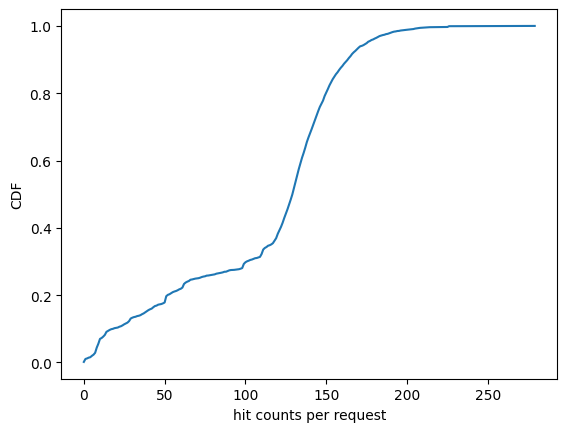

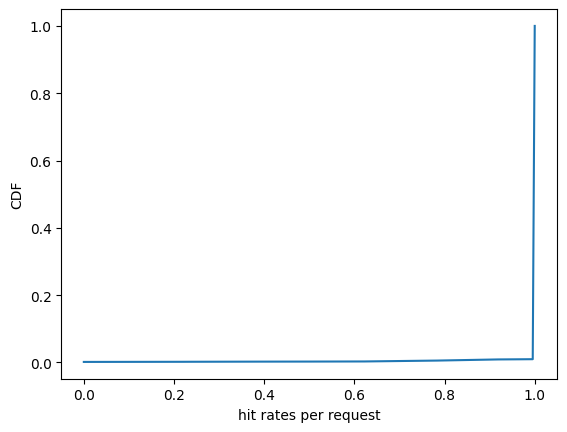

In [12]:
# plot a CDF for the hit counts and hit rates

from matplotlib import pyplot as plt
import numpy as np

hit_counts_sorted = np.sort(np.array(df["hit_count"]))
hit_rates_sorted = np.sort(np.array(df["hit_rate"]))

# plot the CDF of the hit counts
plt.plot(*get_cdf_xy(hit_counts_sorted))
plt.xlabel("hit counts per request")
plt.ylabel("CDF")
plt.show()

# plot the CDF of the hit rates
plt.plot(*get_cdf_xy(hit_rates_sorted))
plt.xlabel("hit rates per request")
plt.ylabel("CDF")
plt.show()

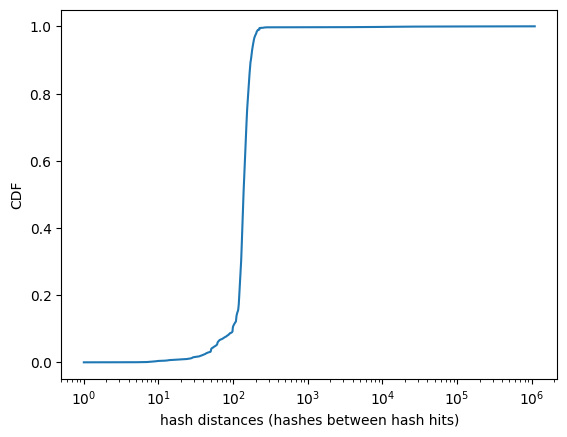

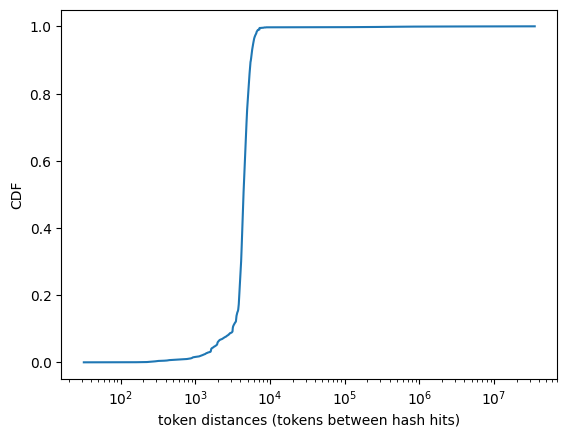

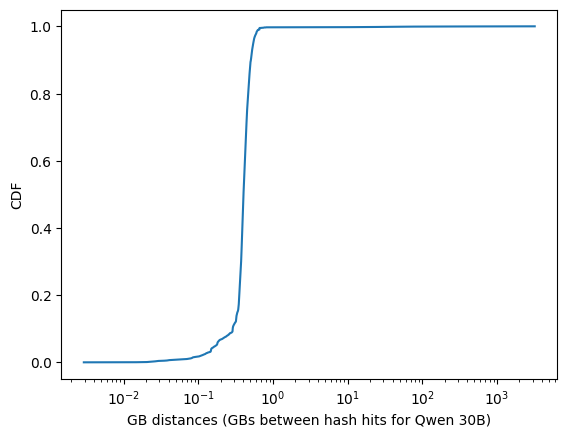

In [13]:
# Plot a CDF for the hash distances, token distances, and GB distances

from matplotlib import pyplot as plt
import numpy as np

hash_distances = np.sort(np.array(global_chunk_cache.hash_distances))
token_distances = hash_distances * 32
gb_distances = token_distances * 0.00009150208

# plot the CDF of the hash distances
plt.plot(*get_cdf_xy(hash_distances))
plt.xlabel("hash distances (hashes between hash hits)")
plt.ylabel("CDF")
plt.xscale("log")
plt.show()

# plot the CDF of the token distances
plt.plot(*get_cdf_xy(token_distances))
plt.xlabel("token distances (tokens between hash hits)")
plt.ylabel("CDF")
plt.xscale("log")
plt.show()

# plot the CDF of the GB distances
plt.plot(*get_cdf_xy(gb_distances))
plt.xlabel("GB distances (GBs between hash hits for Qwen 30B)")
plt.ylabel("CDF")
plt.xscale("log")
plt.show()

# Analyze the dataset in more detail

## 1. let's find some overarching statistics

What is the total duration of the trace and the burstiness of the requests

What are the (min, max, mean, median) input lengths, output lengths, input / output ratios? 

What is the concentration of requests over time? 

## 2. let's analyze the most concentrated section of the trace

In [17]:
total_duration = df["timestamp"].max() - df["timestamp"].min()
print(f"total duration: {total_duration}")
queries_per_second = len(df) / total_duration.seconds
print(f"queries_per_second: {queries_per_second}")


total duration: 0 days 00:59:58.821565374
queries_per_second: 53.5319622012229


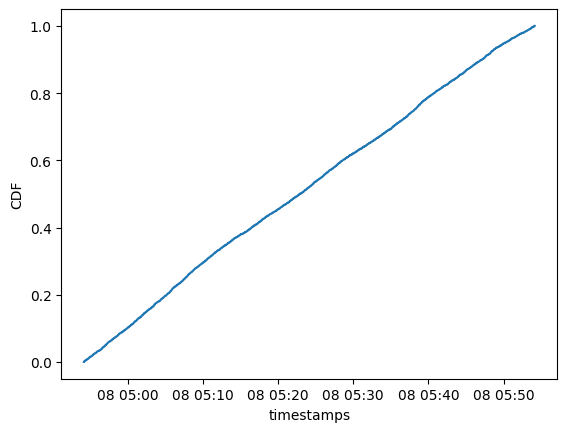

In [18]:
# plot a CDF for requests

timestamps = np.array(df["timestamp"])

# plot the CDF of the indices
plt.plot(*get_cdf_xy(timestamps))
plt.xlabel("timestamps")
plt.ylabel("CDF")
plt.show()

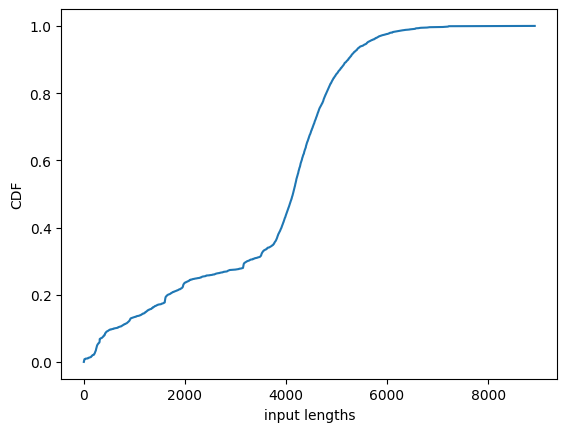

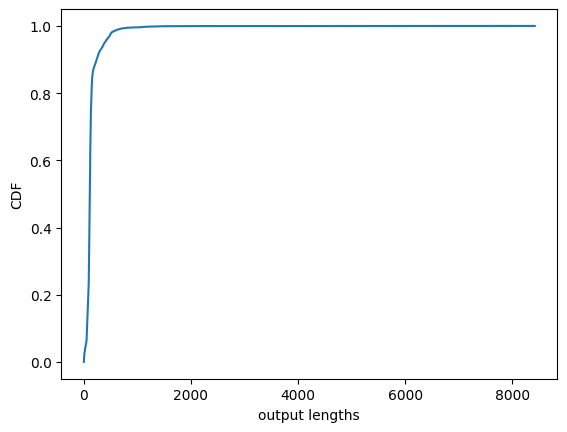

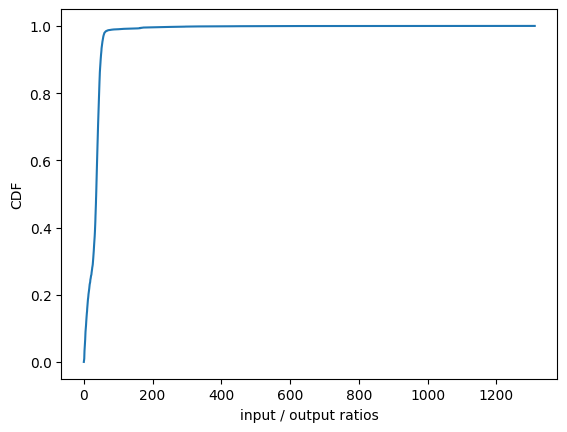

In [67]:
input_lengths = df["input_length"]
output_lengths = df["output_length"]
input_output_ratios = input_lengths / output_lengths

# plot the CDF of the input lengths
plt.plot(*get_cdf_xy(input_lengths))
plt.xlabel("input lengths")
plt.ylabel("CDF")
plt.show()

# plot the CDF of the output lengths
plt.plot(*get_cdf_xy(output_lengths))
plt.xlabel("output lengths")
plt.ylabel("CDF")
plt.show()

# plot the CDF of the input / output ratios
plt.plot(*get_cdf_xy(input_output_ratios))
plt.xlabel("input / output ratios")
plt.ylabel("CDF")
plt.show()